In [1]:
import torch
from torch import nn 
import numpy as np
from PIL import Image
from skimage.transform import resize
import skimage
import itertools
import scipy
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random

## Headers
Change these cells below to skip certain aspects of the notebook. 

Recommended: Get pretrained models, and disable everything except LOAD_MODEL.

It is also recommended to keep the file hierarchy in the GitHub repository.

In [2]:
LOAD_IMG = False
LOAD_DATA  = False
LOAD_MODEL = True
GENERATE_DATA = False
TRAIN = False

In [3]:
MODEL_PATH = '../models/'
TRAIN_PATH = '../training/'
TEST_PATH = '../test_set_images/'
DATA_PATH = '../data/'

## CUDA
We heavily recommend CUDA. If you don't have it, clone the repository to a server and run it there

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model and Function Definitions

In [5]:
def display_image(img):
    plt.imshow(np.transpose(img,(1,2,0)))

In [6]:
class WNetNode(nn.Module):
    def __init__(self, in_channels, out_channels, last=False, activation=nn.LeakyReLU(), kernel_size=3, padding=1):
        super(WNetNode,self).__init__()
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = activation
        self.layer1 = nn.Conv2d(in_channels,out_channels, kernel_size=kernel_size,padding=padding)
        self.layer2 = nn.Conv2d(out_channels,out_channels,kernel_size=kernel_size,padding=padding)
        self.last = last
        
    def forward(self, x):
        o1 = self.layer1(x)
        o1 = self.batchnorm1(o1)
        o1 = self.activation(o1)
        o2 = self.layer2(o1)
        o2 = self.batchnorm2(o2)
        if self.last:
            return o2
        else:
            return self.activation(o2)

In [7]:
class ShatzNet(nn.Module):
    
    def __init__(self,deep=False):
        super(ShatzNet, self).__init__()
        
        #WNet
        self.x00 = WNetNode(3,  64,  last=False)
        self.x10 = WNetNode(64, 128, last=False)
        self.x20 = WNetNode(128,256, last=False)
        self.x30 = WNetNode(256,512, last=False)
        self.x40 = WNetNode(512,1024,last=False)
        
        self.xm1 = WNetNode(128,  64, last=False)
        self.xm2 = WNetNode(256,  128,last=False)
        self.xm3 = WNetNode(512,  256,last=False)
        self.xm4 = WNetNode(1024, 512,last=False)
        
        self.x31 = WNetNode(1024,512,last=False)
        self.x22 = WNetNode(512, 256,last=False)
        self.x13 = WNetNode(256, 128,last=False)
        self.x04 = WNetNode(128, 64, last=False)
        
        self.up1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        self.up2 = nn.ConvTranspose2d(512,256, kernel_size=2,stride=2)
        self.up3 = nn.ConvTranspose2d(256,128, kernel_size=2,stride=2)
        self.up4 = nn.ConvTranspose2d(128,64,  kernel_size=2,stride=2)
        
        self.mp1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        self.mp2 = nn.ConvTranspose2d(512,256, kernel_size=2,stride=2)
        self.mp3 = nn.ConvTranspose2d(256,128, kernel_size=2,stride=2)
        self.mp4 = nn.ConvTranspose2d(128,64,  kernel_size=2,stride=2)
        
        self.wlst = WNetNode(64, 1,last=False)
        
        #UNet
        self.y00 = WNetNode(1,  64,  last=False)
        self.y10 = WNetNode(64, 128, last=False)
        self.y20 = WNetNode(128,256, last=False)
        self.y30 = WNetNode(256,512, last=False)
        self.y40 = WNetNode(512,1024,last=False)
        
        self.y31 = WNetNode(1024,512,last=False)
        self.y22 = WNetNode(512, 256,last=False)
        self.y13 = WNetNode(256, 128,last=False)
        self.y04 = WNetNode(128, 64, last=False)
        self.ulst = WNetNode(64,  1,  last=True)
        
        self.yup1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        self.yup2 = nn.ConvTranspose2d(512,256, kernel_size=2,stride=2)
        self.yup3 = nn.ConvTranspose2d(256,128, kernel_size=2,stride=2)
        self.yup4 = nn.ConvTranspose2d(128,64,  kernel_size=2,stride=2)
        
    def forward(self,x):
        #propagate through wnet
        o1  = self.x00(x)                       #o1 :512x512 x 64
        o1d = nn.MaxPool2d(2)(o1)               #o1d:256x256 x 64
        o2  = self.x10(o1d)                     #o2 :256x256 x 128
        o2d = nn.MaxPool2d(2)(o2)               #o2d:128x128 x 128
        o3  = self.x20(o2d)                     #o3 :128x128 x 256
        o3d = nn.MaxPool2d(2)(o3)               #o3d:64x64   x 256
        o4  = self.x30(o3d)                     #o4 :64x64   x 512
        o4d = nn.MaxPool2d(2)(o4)               #o4d:32x32   x 512
        
        b = self.x40(o4d)                       #b  :32x32   x 1024
        
        #intermediate layers
        mi1 = self.mp1(b)                       #mi1:64x64   x 512
        mo1 = self.xm4(torch.cat([mi1,o4],1))   #mo1:64x64   x 512
        mi2 = self.mp2(mo1)                     #mi2:128x128 x 256
        mo2 = self.xm3(torch.cat([mi2,o3],1))   #mo2:128x128 x 256
        mo2  = nn.Dropout(0.5)(mo2)
        mi3 = self.mp3(mo2)                     #mi3:256x256 x 128
        mo3 = self.xm2(torch.cat([mi3,o2],1))   #mo3:256x256 x 128
        mo3  = nn.Dropout(0.5)(mo3)
        mi4 = self.mp4(mo3)                     #mi4:512x512 x 64
        mo4 = self.xm1(torch.cat([mi4,o1],1))   #mo4:512x512 x 64
        
        o5u = self.up1(b)                       #o5u:64x64   x 512
        o6  = self.x31(torch.cat([o5u,mo1],1))  #o6 :64x64   x 512
        o6  = nn.Dropout(0.5)(o6)
        o6u = self.up2(o6)                      #o6u:128x128 x 256
        o7  = self.x22(torch.cat([o6u,mo2],1))  #o7 :128x128 x 256
        o7  = nn.Dropout(0.5)(o7)
        o7u = self.up3(o7)                      #o7u:256x256 x 128
        o8  = self.x13(torch.cat([o7u,mo3],1))  #o8: 256x256 x 128
        o8  = nn.Dropout(0.5)(o8)
        o8u = self.up4(o8)                      #o8u:512x512 x 64
        o9  = self.x04(torch.cat([o8u,mo4],1))  #o9: 512x512 x 64

        out_w = self.wlst(o9)                   #out_w:512x512 x 1
        
        #propagate through unet
        yo1  = self.y00(out_w)                    #yo1 :512x512 x 64
        yo1d = nn.MaxPool2d(2)(yo1)               #yo1d:256x256 x 64
        yo2  = self.y10(yo1d)                     #yo2 :256x256 x 128
        yo2d = nn.MaxPool2d(2)(yo2)               #yo2d:128x128 x 128
        yo3  = self.y20(yo2d)                     #yo3 :128x128 x 256
        yo3d = nn.MaxPool2d(2)(yo3)               #yo3d:64x64   x 256
        yo4  = self.y30(yo3d)                     #yo4 :64x64   x 512
        yo4d = nn.MaxPool2d(2)(yo4)               #yo4d:32x32   x 512
        
        yb = self.x40(yo4d)                        #yb  :32x32   x 1024
        
        yo5u = self.yup1(yb)                       #yo5u:64x64   x 512
        yo6  = self.y31(torch.cat([yo5u,yo4],1))   #yo6 :64x64   x 512
        yo6  = nn.Dropout(0.5)(yo6)
        yo6u = self.yup2(yo6)                      #yo6u:128x128 x 256
        yo7  = self.y22(torch.cat([yo6u,yo3],1))   #yo7 :128x128 x 256
        yo7  = nn.Dropout(0.5)(yo7)
        yo7u = self.yup3(yo7)                      #yo7u:256x256 x 128
        yo8  = self.y13(torch.cat([yo7u,yo2],1))   #yo8: 256x256 x 128
        yo8  = nn.Dropout(0.5)(yo8)
        yo8u = self.yup4(yo8)                      #yo8u:512x512 x 64
        yo9  = self.y04(torch.cat([yo8u,yo1],1))   #yo9: 512x512 x 64
        
        yout = self.ulst(yo9)                     #yout:512x512 x 1
        yout = nn.Sigmoid()(yout)                 #logit last layer
        return yout

In [8]:
def DiceLoss(y_pred, y_true, eps=1e-6):
    return 1 - (2 * (y_pred * y_true).sum()+eps) / ((y_pred ** 2).sum() + (y_true ** 2).sum() + eps)

In [9]:
if LOAD_MODEL:
    net = ShatzNet()
    net.load_state_dict(torch.load(MODEL_PATH+'model_shatznet_god.model')['model_state_dict'])
else:
    net = ShatzNet()
if use_cuda:
    net.cuda()

In [10]:
def batch(images,labels,batch_size):
    k=0
    while k < images.shape[0]:
        yield images[k:min(k+batch_size,images.shape[0])], labels[k:min(k+batch_size,labels.shape[0])]
        k+=batch_size

## Data Generation

In [11]:
#read data
if LOAD_IMG:
    images = np.zeros(shape=(100,3,320,320))
    labels = np.empty(shape=(100,1,320,320))
    for i in tqdm(range(1,101)):
        image = np.array(Image.open(f'{TRAIN_PATH}/images/satImage_{str(i).zfill(3)}.png')).astype(np.float)/255
        label = np.array(Image.open(f'{TRAIN_PATH}/groundtruth/satImage_{str(i).zfill(3)}.png')).astype(np.float)/255
        image = resize(image,(320,320))
        label = resize(label,(320,320))
        image = np.expand_dims(np.transpose(image,(2,0,1)),0)
        label = np.expand_dims(label,0)
        images[i-1,:,:,:] = image
        labels[i-1,:,:,:] = label

In [12]:
if GENERATE_DATA:
    np.random.seed(69)
    
    rotations = [0,30,60,90]
    no_rotations = 4
    
    translation_range = (-8,8)
    no_translations = 2
    
    brightness = [0.8,1]
    no_brightness = 2
    
    zooms = [0.5,0.75,1,1.50]
    no_zooms = 4

    augmented_images = np.zeros(shape=(len(images)*no_rotations*no_translations*no_brightness*no_zooms,3,320,320))
    augmented_labels = np.zeros(shape=(len(labels)*no_rotations*no_translations*no_brightness*no_zooms,1,320,320))
    k=0
    for i in tqdm(range(images.shape[0])):
        for R in rotations:
            for T in range(no_translations):
                for B in range(no_brightness):
                    for zoom in zooms:
                        Ro_r = R
                        Tx_r = np.random.uniform(low=translation_range[0], high=translation_range[1], size=1)[0]
                        Ty_r = np.random.uniform(low=translation_range[0], high=translation_range[1], size=1)[0]
                        Br_r = brightness[B]
                        
                        px = np.abs(int(320*(1-zoom))//2)
                        py = np.abs(int(320*(1-zoom))//2)
                        if zoom <= 1:
                            zoom_img = np.pad(scipy.ndimage.zoom(np.transpose(images[i],(1,2,0)),(zoom,zoom,1),mode='reflect'),((px,px),(py,py),(0,0)),mode='reflect')
                        else:
                            zoom_img = scipy.ndimage.zoom(np.transpose(images[i],(1,2,0)),(zoom,zoom,1),mode='reflect')
                            zoom_img = zoom_img[px:zoom_img.shape[0]-px,py:zoom_img.shape[1]-py,:]
                        rot_img = scipy.ndimage.rotate(zoom_img, Ro_r, reshape=False, mode='reflect')
                        trn_img = scipy.ndimage.shift(rot_img,(Tx_r,Ty_r,0), mode='reflect')
                        
                        if zoom <= 1:
                            zoom_lab = np.pad(scipy.ndimage.zoom(np.transpose(labels[i],(1,2,0)),(zoom,zoom,1),mode='reflect'),((px,px),(py,py),(0,0)),mode='reflect')
                        else:
                            zoom_lab = scipy.ndimage.zoom(np.transpose(labels[i],(1,2,0)),(zoom,zoom,1),mode='reflect')
                            zoom_lab = zoom_lab[px:zoom_lab.shape[0]-px,py:zoom_lab.shape[1]-py]
                        rot_lab = scipy.ndimage.rotate(zoom_lab, Ro_r, reshape=False, mode='reflect')
                        trn_lab = scipy.ndimage.shift(rot_lab,(Tx_r,Ty_r,0), mode='reflect')
                        
                        fin_img = np.transpose(Br_r*trn_img,(2,0,1))
                        fin_lab = np.transpose(trn_lab,(2,0,1)) > 0.3
                        augmented_images[k,:,:,:] = np.clip(fin_img,0,1)
                        augmented_labels[k,:,:,:] = fin_lab
                        k+=1
                        
    perm = np.random.permutation(augmented_images.shape[0])
    augmented_images = augmented_images[perm]
    augmented_labels = augmented_labels[perm]
    
    np.save(f'{DATA_PATH}augmented_images_train_best',augmented_images)
    np.save(f'{DATA_PATH}augmented_labels_train_best',augmented_labels)

In [13]:
if LOAD_DATA:
    augmented_images_train = np.load(f'{DATA_PATH}augmented_images_train_best.npy')
    augmented_labels_train = np.load(f'{DATA_PATH}augmented_labels_train_best.npy')

## Training

In [14]:
def train_no_valid(net,train_data,train_labels,epochs,loss,eta,batch_size,weight_decay,eps=1e-5):
    optimizer = torch.optim.Adam(net.parameters(),lr=eta,weight_decay=weight_decay)
    running_loss = 0
    print(f'Starting training with eta={eta} for {epochs} epochs, with batch size {batch_size}')

    #training
    for epoch in tqdm(range(epochs)):
        perm = np.random.permutation(train_data.shape[0])
        train_data = train_data[perm]
        train_labels = train_labels[perm]
        k=0
        print(f'Training for Epoch {epoch+1} starting:')
        net.train()
        loss_train = 0
        for img,lab in batch(train_data,train_labels,batch_size):
            if use_cuda:
                inp = torch.from_numpy(img).float().cuda()
                lab = torch.from_numpy(lab).float().cuda()
            else:
                inp = torch.from_numpy(img).float()
                lab = torch.from_numpy(lab).float()
                
            optimizer.zero_grad()
            inference = net(inp)
            loss_v = loss(inference,lab)
            loss_v.backward()
            optimizer.step()
            
            loss_train += loss_v
            running_loss += loss_v
            k+=1
            if k % 10 == 0:
                print(f'Epoch {epoch+1}, avg running_loss: {running_loss/10}')
                running_loss=0
                k = 0
        print(f'Training loss for {epoch+1}:{loss_train}')
        
                    
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, 'MODEL_PATH+model_shatznet_god.model')

In [15]:
if TRAIN:
    train_no_valid(net,train_data=augmented_images_train,train_labels=augmented_labels_train,epochs=30,loss=nn.BCELoss(),eta=3e-4,batch_size=8,weight_decay=1e-6)

In [16]:
if TRAIN:
    train_no_valid(net,train_data=augmented_images_train,train_labels=augmented_labels_train,epochs=15,loss=nn.BCELoss(),eta=3e-5,batch_size=8,weight_decay=1e-7)

In [17]:
if TRAIN:
    train_no_valid(net,train_data=augmented_images_train,train_labels=augmented_labels_train,epochs=15,loss=nn.BCELoss(),eta=3e-6,batch_size=8,weight_decay=1e-8)

### Submission and Model outputs
Change image index and run the following cells to see the outputs of the model

In [18]:
#Change this to change the test image
img_idx = 23

In [19]:
net.eval()
test_img = resize(np.array(Image.open(f'{TEST_PATH}/test_{img_idx}/test_{img_idx}.png')).astype('float32') / 255, (320,320))
test_img_n = np.expand_dims(test_img,0)
test_img_n = torch.from_numpy(np.transpose(test_img_n,(0,3,1,2))).float()
if use_cuda:
    out = net(test_img_n.cuda()).detach().cpu().numpy()
else:
    out = net(test_img_n).detach().numpy()

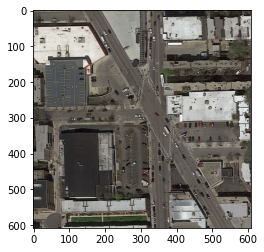

In [20]:
plt.imshow(np.array(Image.open(f'{TEST_PATH}/test_{img_idx}/test_{img_idx}.png')).astype('float32') / 255)

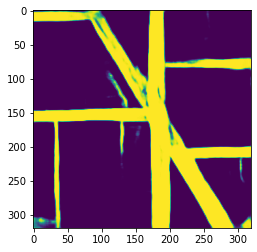

In [21]:
plt.imshow(out[0,0,:,:])

In [22]:
def to_submission(model_output,image_id,median_filter=False):
    csv_arr = []
    if median_filter:
        model_output = scipy.ndimage.median_filter(model_output, 8)
    for i in range(0,model_output.shape[0],16):
        for j in range(0,model_output.shape[1],16):
            prediction = 0
            patch = model_output[j:j+16, i:i+16]
            if np.mean(patch) > 0.25:
                prediction = 1
            csv_arr.append(["{:03d}_{}_{}".format(image_id,i,j),prediction])
    return csv_arr

In [ ]:
outputs = []
for img_idx in tqdm(range(1,51)):
    net.eval()
    test_img = resize(np.array(Image.open(f'{TEST_PATH}/test_{img_idx}/test_{img_idx}.png')).astype('float32') / 255, (320,320))
    test_img_n = np.expand_dims(test_img,0)
    test_img_n = torch.from_numpy(np.transpose(test_img_n,(0,3,1,2))).float()
    if use_cuda:
        out = resize(net(test_img_n.cuda()).detach().cpu().numpy()[0,0,:,:], (608,608))
    else:
        out = resize(net(test_img_n).detach().numpy()[0,0,:,:], (608,608))
    sub_output = to_submission(out,img_idx)
    outputs.append(sub_output)

In [28]:
outputs_np = np.concatenate(outputs,axis=0)
outputs_np = np.concatenate(([['id','prediction']],outputs_np), axis=0)
np.savetxt("submit.csv", outputs_np, delimiter=",", fmt = '%s')